In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import time
from nbodykit.algorithms.fftpower import FFTPower
import gc
from matplotlib import cm
import pyfftw as fftw
import pyccl
import pandas as pd
import struct
from collections import namedtuple

__all__ = ['readGadgetSnapshot', 'GadgetHeader']

__GadgetHeader_fmt = '6I6dddii6Iiiddddii6Ii'

GadgetHeader = namedtuple('GadgetHeader', \
        'npart mass time redshift flag_sfr flag_feedback npartTotal flag_cooling num_files BoxSize Omega0 OmegaLambda HubbleParam flag_age flag_metals NallHW flag_entr_ics')

def readGadgetSnapshot(filename, read_pos=False, read_vel=False, read_id=False,\
        read_mass=False, print_header=False, single_type=-1, lgadget=False):
    """
    This function reads the Gadget-2 snapshot file.

    Parameters
    ----------
    filename : str
        path to the input file
    read_pos : bool, optional
        Whether to read the positions or not. Default is false.
    read_vel : bool, optional
        Whether to read the velocities or not. Default is false.
    read_id : bool, optional
        Whether to read the particle IDs or not. Default is false.
    read_mass : bool, optional
        Whether to read the masses or not. Default is false.
    print_header : bool, optional
        Whether to print out the header or not. Default is false.
    single_type : int, optional
        Set to -1 (default) to read in all particle types.
        Set to 0--5 to read in only the corresponding particle type.
    lgadget : bool, optional
        Set to True if the particle file comes from l-gadget.
        Default is false.

    Returns
    -------
    ret : tuple
        A tuple of the requested data.
        The first item in the returned tuple is always the header.
        The header is in the GadgetHeader namedtuple format.
    """
    blocks_to_read = (read_pos, read_vel, read_id, read_mass)
    ret = []
    with open(filename, 'rb') as f:
        f.seek(4, 1)
        h = list(struct.unpack(__GadgetHeader_fmt, \
                f.read(struct.calcsize(__GadgetHeader_fmt))))
        if lgadget:
            h[30] = 0
            h[31] = h[18]
            h[18] = 0
            single_type = 1
        h = tuple(h)
        header = GadgetHeader._make((h[0:6],) + (h[6:12],) + h[12:16] \
                + (h[16:22],) + h[22:30] + (h[30:36],) + h[36:])
        if print_header:
            print(header)
        if not any(blocks_to_read):
            return header
        ret.append(header)
        f.seek(256 - struct.calcsize(__GadgetHeader_fmt), 1)
        f.seek(4, 1)
        #
        mass_npart = [0 if m else n for m, n in zip(header.mass, header.npart)]
        if single_type not in set(range(6)):
            single_type = -1
        #
        for i, b in enumerate(blocks_to_read):
            fmt = np.dtype(np.float32)
            fmt_64 = np.dtype(np.float64)
            item_per_part = 1
            npart = header.npart
            #
            if i < 2:
                item_per_part = 3
            elif i == 2:
                fmt = np.dtype(np.uint32)
                fmt_64 = np.dtype(np.uint64)
            elif i == 3:
                if sum(mass_npart) == 0:
                    ret.append(np.array([], fmt))
                    break
                npart = mass_npart
            #
            size_check = struct.unpack('I', f.read(4))[0]
            #
            block_item_size = item_per_part*sum(npart)
            if size_check != block_item_size*fmt.itemsize:
                fmt = fmt_64
            if size_check != block_item_size*fmt.itemsize:
                raise ValueError('Invalid block size in file!')
            size_per_part = item_per_part*fmt.itemsize
            #
            if not b:
                f.seek(sum(npart)*size_per_part, 1)
            else:
                if single_type > -1:
                    f.seek(sum(npart[:single_type])*size_per_part, 1)
                    npart_this = npart[single_type]
                else:
                    npart_this = sum(npart)
                data = np.fromstring(f.read(npart_this*size_per_part), fmt)
                if item_per_part > 1:
                    data.shape = (npart_this, item_per_part)
                ret.append(data)
                if not any(blocks_to_read[i+1:]):
                    break
                if single_type > -1:
                    f.seek(sum(npart[single_type+1:])*size_per_part, 1)
            f.seek(4, 1)
    #
    return tuple(ret)

def position_to_index(pos, lbox, nmesh):
    
    deltax = lbox/nmesh
    
    
    idvec = np.floor((pos)/deltax) 
    
    return (idvec%nmesh).astype('int16')

def diracdelta(i, j):
    if i == j:
        return 1
    else:
        return 0

# icdir = glob('/u/ki/jderose/desims/tinkers_emu/Box000/ics_z9/ics.*')
# icdir.sort()

# fdir = glob('/nfs/slac/g/ki/ki22/cosmo/beckermr/tinkers_emu/Box000/output/snapdir_009/snapshot_009.*')

# Make the linear density field with input P(k)

In [2]:
from scipy.interpolate import interp1d


# k, pk = np.loadtxt('/u/ki/nkokron/des/ptbias_emu/pklin_box000_ic.txt').T

In [3]:
#Making the P(k) for Aemulus box 0 from which we'll generate mocks

cosmofiles = pd.read_csv('~jderose/public_html/aemulus/phase1/cosmos.txt', sep=' ')

box0cosmo = cosmofiles.iloc[0]

cosmo = pyccl.Cosmology(Omega_b= box0cosmo['ombh2']/(box0cosmo['H0']/100)**2, Omega_c = 1.4*box0cosmo['omch2']/(box0cosmo['H0']/100)**2,
                       h = box0cosmo['H0']/100, n_s = box0cosmo['ns'], w0=box0cosmo['w0'], Neff=box0cosmo['Neff'],
                        sigma8 = box0cosmo['sigma8'])

k = np.logspace(-5, 2.3, 1000)

#Pk in h/Mpc units
pk = pyccl.linear_matter_power(cosmo, k*box0cosmo['H0']/100, 1)*(box0cosmo['H0']/100)**3
#Computing growth factor
z_ic = 49

D = pyccl.growth_factor(cosmo, 1./(1+z_ic))

#Rescaling P(k) back to z_IC
fpk = interp1d(k, pk*D**2)



# Making the Zeldovich approximated catalog

In [4]:
from nbodykit import mockmaker
from pmesh.pm import ParticleMesh
from nbodykit.source.mesh import ArrayMesh

Lbox = 1050
nmesh = 512
seed = 1

In [5]:
newmesh = ParticleMesh(BoxSize=Lbox, Nmesh=[nmesh, nmesh, nmesh])

#Making delta and displacements, checked that this agrees with home-grown NGen-IC (modulo seed)
delta, disp = mockmaker.gaussian_real_fields(newmesh, fpk, seed, compute_displacement=True)

# Making Lagrangian IC field

In [6]:
#How NBodykit indexes grid coordinates according to "field.x"
coord = np.linspace(0, Lbox, nmesh+1)[:-1]

In [7]:
xx, yy, zz = np.meshgrid(coord, coord, coord, indexing='ij')

In [8]:
testgrid = np.stack([xx,yy,zz])

In [9]:
z_late = 1

growthratio = pyccl.growth_factor(cosmo, 1./(1+z_late))/pyccl.growth_factor(cosmo, 1./(1+z_ic))

In [10]:
# displacements = np.stack([disp[0], disp[1], disp[2]])

In [11]:
#Lagrangian ICs for component fields
testgrid = 1.*np.stack([xx,yy,zz])

movedgrid = 1.*testgrid

for i in range(3):
    movedgrid[i] += disp[i]
    
movedgrid = movedgrid%Lbox
movedgrid = movedgrid.reshape(3, nmesh**3)

In [12]:
# movedgrid.reshape(3, nmesh**3)

In [13]:
del xx, yy, zz
gc.collect()

87

In [14]:
#Late-time 'non-linear' zeldovich field

lategrid = 1.*testgrid
for i in range(3):
    lategrid[i] += disp[i]*growthratio
lategrid = lategrid%Lbox
lategrid = lategrid.reshape(3, nmesh**3)

In [15]:
del testgrid
gc.collect()

40

# Pasting moved grid into mesh

In [16]:
#Painting the Lagrangian IC fields to a mesh

from nbodykit.source.catalog import ArrayCatalog
nbodycat = np.empty(nmesh**3, dtype=[('Position', ('f8', 3))])
nbodycat['Position'] = movedgrid.T

cat = ArrayCatalog(nbodycat, Nmesh=nmesh, BoxSize=Lbox)
mesh = cat.to_mesh(Nmesh=nmesh, BoxSize=Lbox)
field_zeldovich = (mesh.paint(mode='real')-1)

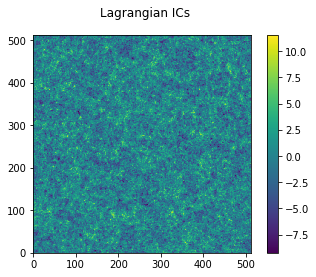

In [17]:
plt.imshow(field_zeldovich.preview(axes=[0,1]), origin='lower')
plt.suptitle('Lagrangian ICs')
plt.colorbar()

In [18]:
#Painting the late-time ZA particles to a mesh


nbodycat = np.empty(nmesh**3, dtype=[('Position', ('f8', 3))])
nbodycat['Position'] = lategrid.T

cat = ArrayCatalog(nbodycat, Nmesh=nmesh, BoxSize=Lbox)
mesh = cat.to_mesh(Nmesh=nmesh, BoxSize=Lbox) 

field_late = (mesh.paint(mode='real')-1)

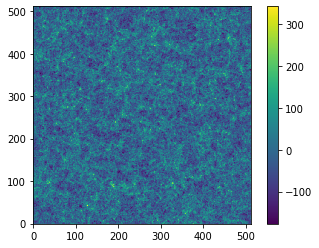

In [19]:
plt.imshow(field_late.preview(axes=[0,1]), origin='lower')
plt.colorbar()

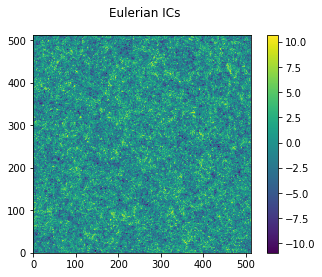

In [20]:
#Visualizing Eulerian ICs
plt.imshow((delta).preview(axes=[0,1]), origin='lower')
plt.suptitle('Eulerian ICs')
plt.colorbar()

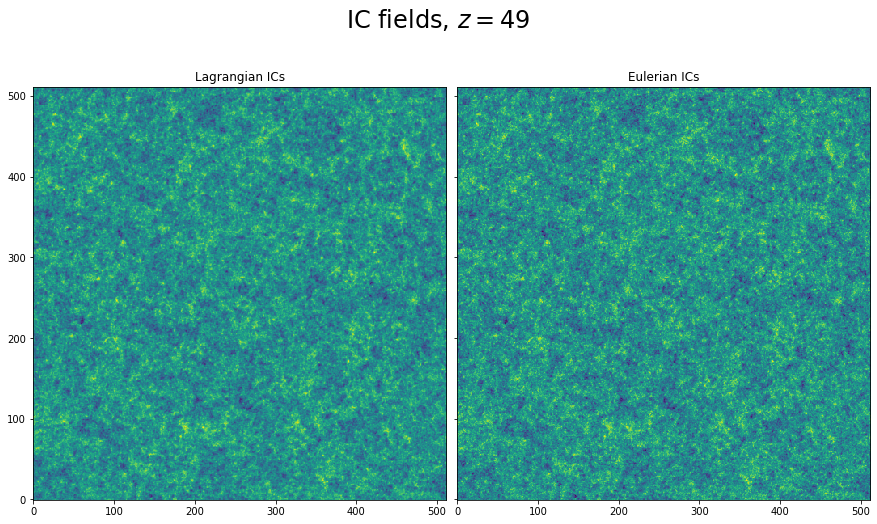

In [21]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(15, 8))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 share_all=True,
#                  cbar_location="right",
#                  cbar_mode="single",
#                  cbar_size="7%",
#                  cbar_pad=0.15,
                 )
maxval = np.max(delta.preview(axes=[0,1]))
minval = np.min(delta.preview(axes=[0,1]))

grid[0].imshow(field_zeldovich.preview(axes=[0,1]), origin='lower', vmin=minval, vmax=maxval)
grid[0].set_title(r'Lagrangian ICs')

grid[1].imshow(delta.preview(axes=[0,1]), vmin=minval, vmax=maxval, origin='lower')
grid[1].set_title(r'Eulerian ICs')

fig.suptitle('IC fields, $z=%s$'%z_ic, y=1.0, fontsize=24)
fig.show()

In [22]:
bins = np.linspace(-1, 2, 100)

linh, b = np.histogram(delta.value.flatten(), bins=bins, density=True)
linx = (b[:-1]+b[1:])/2.

zah, b = np.histogram(field_zeldovich.value.flatten(), bins=bins, density=True)
zax = (b[:-1]+b[1:])/2.

lateh, b = np.histogram(field_late.value.flatten(), bins=bins, density=True)
latex = (b[:-1]+b[1:])/2.



(-1.0, 2)

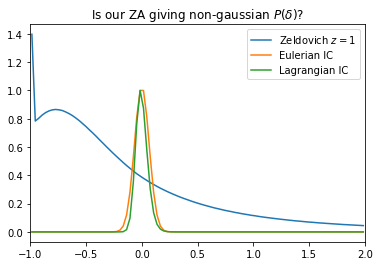

In [23]:
plt.plot(latex, lateh, label='Zeldovich $z=%s$'%z_late)
plt.plot(linx, linh/np.max(linh), label='Eulerian IC')
plt.plot(zax, zah/np.max(zah), label='Lagrangian IC')
plt.title(r'Is our ZA giving non-gaussian $P(\delta)$?')
plt.legend()
plt.xlim(-1., 2)

In [24]:
#How do the $P(k)$ look?
ZApower = FFTPower(field_zeldovich, '1d', second=field_zeldovich, BoxSize=Lbox, Nmesh=nmesh)
linpower = FFTPower(delta, '1d', second=delta, BoxSize=Lbox, Nmesh=nmesh)
latepower = FFTPower(field_late, '1d', second=field_late, BoxSize=Lbox, Nmesh=nmesh)
# plt.hlines(1./(512/Lbox)**3, 1e-2, 1)

In [25]:
# truelin = pyccl.linear_matter_power(cosmo, latepower.power['k']*(box0cosmo['H0']/100), 0.33333)*(box0cosmo['H0']/100)**3

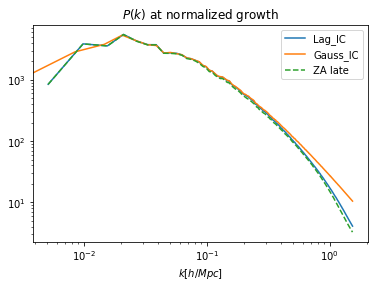

In [26]:
plt.loglog(ZApower.power['k'], growthratio**2 * ZApower.power['power'].real, label='Lag_IC')
plt.loglog(linpower.power['k'], growthratio**2 * linpower.power['power'].real, label='Gauss_IC')
plt.loglog(latepower.power['k'], latepower.power['power'].real, ls='--', label='ZA late')
# plt.loglog(k, pk*(0.3333)**2, label='CCL')
# plt.xlim(8e-3, 1)
# plt.ylim(1e2, 5e3)
# plt.loglog(latepower.power['k'], symmtest)
plt.title(r'$P(k)$ at normalized growth')
plt.xlabel(r'$k[h/Mpc]$')
plt.legend()

/afs/slac.stanford.edu/u/ki/nkokron/miniconda2/envs/CCL/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


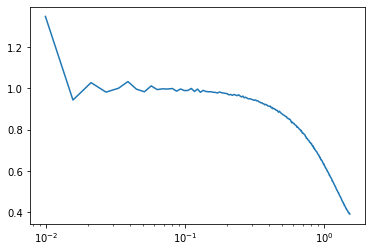

In [27]:
plt.plot(ZApower.power['k'], ZApower.power['power'].real/linpower.power['power'].real)
plt.xscale('log')
# plt.ylim(0.4, 0.6)

# Isotropy tests for ZA?

zpower = FFTPower(field_zeldovich, '2d', Nmu=5, los=[0,0,1], BoxSize=Lbox, Nmesh=nmesh)
ypower = FFTPower(field_zeldovich, '2d', Nmu=5, los=[0,1,0], BoxSize=Lbox, Nmesh=nmesh)
xpower = FFTPower(field_zeldovich, '2d', Nmu=5, los=[1,0,0], BoxSize=Lbox, Nmesh=nmesh)


for i in range(zpower.power.shape[1]):
    Pk = zpower.power[:,i] # select the ith mu bin
    label = r'$\mu$=%.1f' % (zpower.power.coords['mu'][i])
    plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'], label=label)
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title('Z-axis projected anisotropic $P(k)$')
plt.xlim(0.01, 0.6)

for i in range(xpower.power.shape[1]):
    Pk = xpower.power[:,i] # select the ith mu bin
    label = r'$\mu$=%.1f' % (xpower.power.coords['mu'][i])
    plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'], label=label)
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title('Y-axis projected anisotropic $P(k)$')

plt.xlim(0.01, 0.6)

for i in range(xpower.power.shape[1]):
    Pk = xpower.power[:,i] # select the ith mu bin
    label = r'$\mu$=%.1f' % (xpower.power.coords['mu'][i])
    plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'], label=label)
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title('X-axis projected anisotropic $P(k)$')

plt.xlim(0.01, 0.6)

# Component fields

In [28]:
#Rescale IC fields by growth rate at late time
#Commenting this out because this is done later on when measuring the $P(k)$s
# field_zeldovich = growthratio*field_zeldovich

In [29]:
#delta_L^2, this is presumably just the square of delta_L

sqfield = field_zeldovich**2

sqfield -= sqfield.cmean()

### FFT

In [30]:
def delta_to_tidesq(delta_k, nmesh, lbox):
    #Assumes delta_k is a pyfftw fourier-transformed density contrast field
    #Computes the tidal tensor tau_ij = (k_i k_j/k^2  - delta_ij/3 )delta_k
    #Returns it as an nbodykit mesh
    
    
    kvals = np.fft.fftfreq(nmesh)*(2*np.pi*nmesh)/lbox
    kvalsr = np.fft.rfftfreq(nmesh)*(2*np.pi*nmesh)/lbox
    
    kx, ky, kz = np.meshgrid(kvals, kvals, kvalsr, indexing='ij')
    
    
    knorm = kx**2 + ky**2 + kz**2
    knorm[0][0][0] = 1
    klist = [[kx, kx], [kx, ky], [kx, kz], [ky, ky], [ky, kz], [kz, kz]]
    
    del kx, ky, kz
    gc.collect()
    
    
    #Compute the symmetric tide at every Fourier mode which we'll reshape later
    
    #Order is xx, xy, xz, yy, yz, zz
    
    
    jvec = [[0,0], [0,1], [0,2], [1,1], [1,2], [2,2]]
    tidesq = np.zeros(shape=(len(kvals), len(kvals), len(kvals)))

    #Transform each ij component individually, add to tide^2
    #s_ik s_kj = s_ii^2 + 2s_ij^2 for relevant i's, j's
    for i in range(len(klist)):
        fft_tide = np.array((klist[i][0]*klist[i][1]/knorm - diracdelta(jvec[i][0], jvec[i][1]) /3.) * (delta_k), dtype='complex64')
        real_tide = fftw.interfaces.numpy_fft.irfftn(fft_tide, axes=[0, 1, 2], threads=-1, auto_align_input=True)
        tidesq += real_tide**2
        if jvec[i][0] != jvec[i][1]:
            tidesq+= real_tide**2
            
    del real_tide, fft_tide
    gc.collect()
#     fft_tide = fftw.byte_align(fft_tide, dtype='complex64')
    
#     real_tide = fftw.interfaces.numpy_fft.irfftn(fft_tide, axes=[0, 1, 2], threads=-1, auto_align_input=True)
        
    
    #More efficient than the einsum? 
    #For less memory usage don't do fft_tide first.
#     for i in range(6):
#         tidesq += real_tide[i]**2
#         if jvec[i][0] != jvec[i][1]:
#             tidesq+= real_tide[i]**2
     
    return ArrayMesh(tidesq, BoxSize=lbox).to_real_field()

#Not using right now 
def delta_to_gradsqdelta(delta_k, nmesh, lbox):
    
    kvals = np.fft.fftfreq(nmesh)*(2*np.pi*nmesh)/lbox
    kvalsr = np.fft.rfftfreq(nmesh)*(2*np.pi*nmesh)/lbox
    
    kx, ky, kz = np.meshgrid(kvals, kvals, kvalsr, indexing='ij')
    
    
    knorm = kx**2 + ky**2 + kz**2
    knorm[0][0][0] = 1
    
    ksqdelta = knorm*delta_k
    
    ksqdelta = fftw.byte_align(ksqdelta, dtype='complex64')
    
    gradsqdelta = fftw.interfaces.numpy_fft.irfftn(ksqdelta, axes=[0,1,2], threads=-1)

    
    return ArrayMesh(gradsqdelta, BoxSize=lbox).to_real_field()
    


In [31]:
#Aligning everything so fftw plays nice

linfield = fftw.byte_align(field_zeldovich.value, dtype='float32')

linfield = ArrayMesh(linfield, BoxSize=Lbox).to_real_field()

field_fft = fftw.interfaces.numpy_fft.rfftn(linfield, threads=-1)

In [32]:
tidesq = delta_to_tidesq(field_fft, nmesh=nmesh, lbox=Lbox)


In [33]:
tidesq -= tidesq.cmean()

# Plots 

##

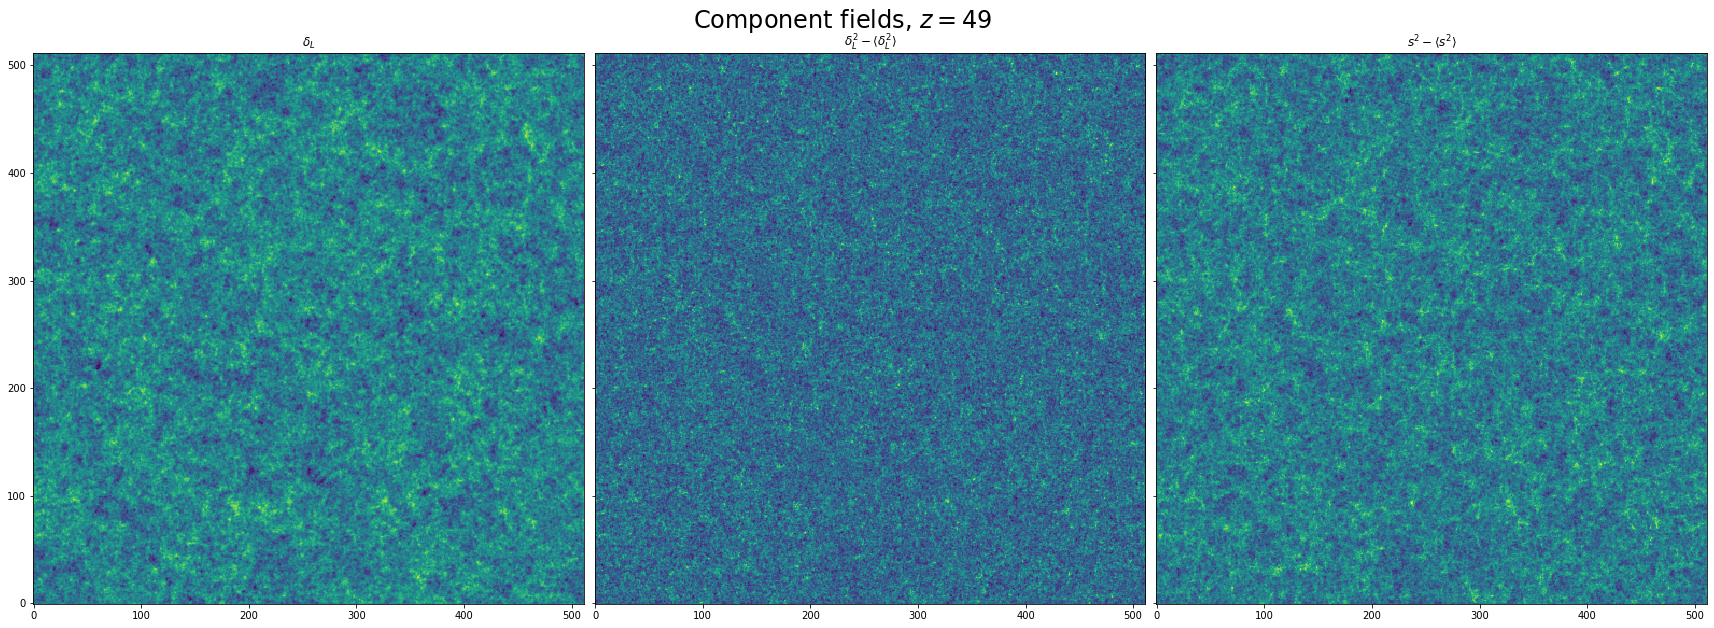

In [34]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(30, 15))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,

                 )
# maxval = np.max(sqfield.preview(axes=[0,1]))
# minval = np.min(sqfield.preview(axes=[0,1]))

grid[0].imshow(linfield.preview(axes=[0,1]), origin='lower')
grid[0].set_title(r'$\delta_L$')

grid[1].imshow(sqfield.preview(axes=[0,1]), origin='lower')
im = grid[2].imshow(tidesq.preview(axes=[0,1]), origin='lower')
grid[1].set_title(r'$\delta_L^2 - \langle \delta_L^2 \rangle $')

grid[2].cax.colorbar(im)
grid[2].cax.toggle_label(True)
grid[2].set_title(r'$s^2 - \langle s^2 \rangle $')

fig.suptitle('Component fields, $z=%s$'%z_ic, y=0.8, fontsize=24)
fig.show()

# Advected fields

In [35]:
#Making linear field first:
#subtracting out field_late due to occasional nbodykit bug which will set all weights to zero for some unclear reason
#Have tested the subtraction procedure gives equivalent fields (up to numerical noise)
#Should prob make this whole cell a function so don't have 3x repeats but ok.

nbodycat = np.empty(nmesh**3, dtype=[('Position', ('f8', 3)), ('Weight', 'f8')])
nbodycat['Position'] = lategrid.T
nbodycat['Weight'] = field_zeldovich.value.reshape(nmesh**3)+1


cat = ArrayCatalog(nbodycat, Nmesh=nmesh, BoxSize=Lbox)
mesh = cat.to_mesh(Nmesh=nmesh, BoxSize=Lbox, weight='Weight')

field_linlate = (mesh.paint(mode='real')-1)
field_linlate -= field_late

In [36]:
nbodycat = np.empty(nmesh**3, dtype=[('Position', ('f8', 3)), ('Weight', 'f8')])
nbodycat['Position'] = lategrid.T
nbodycat['Weight'] = sqfield.value.reshape(nmesh**3)+1


cat = ArrayCatalog(nbodycat, Nmesh=nmesh, BoxSize=Lbox)
mesh = cat.to_mesh(Nmesh=nmesh, BoxSize=Lbox, weight='Weight')

field_sqlate = (mesh.paint(mode='real')-1)
field_sqlate -= field_late

In [37]:
nbodycat = np.empty(nmesh**3, dtype=[('Position', ('f8', 3)), ('Weight', 'f8')])
nbodycat['Position'] = lategrid.T
nbodycat['Weight'] = tidesq.value.reshape(nmesh**3)+1


cat = ArrayCatalog(nbodycat, Nmesh=nmesh, BoxSize=Lbox)
mesh = cat.to_mesh(Nmesh=nmesh, BoxSize=Lbox, weight='Weight')

tide_sqlate = (mesh.paint(mode='real')-1)
tide_sqlate -= field_late

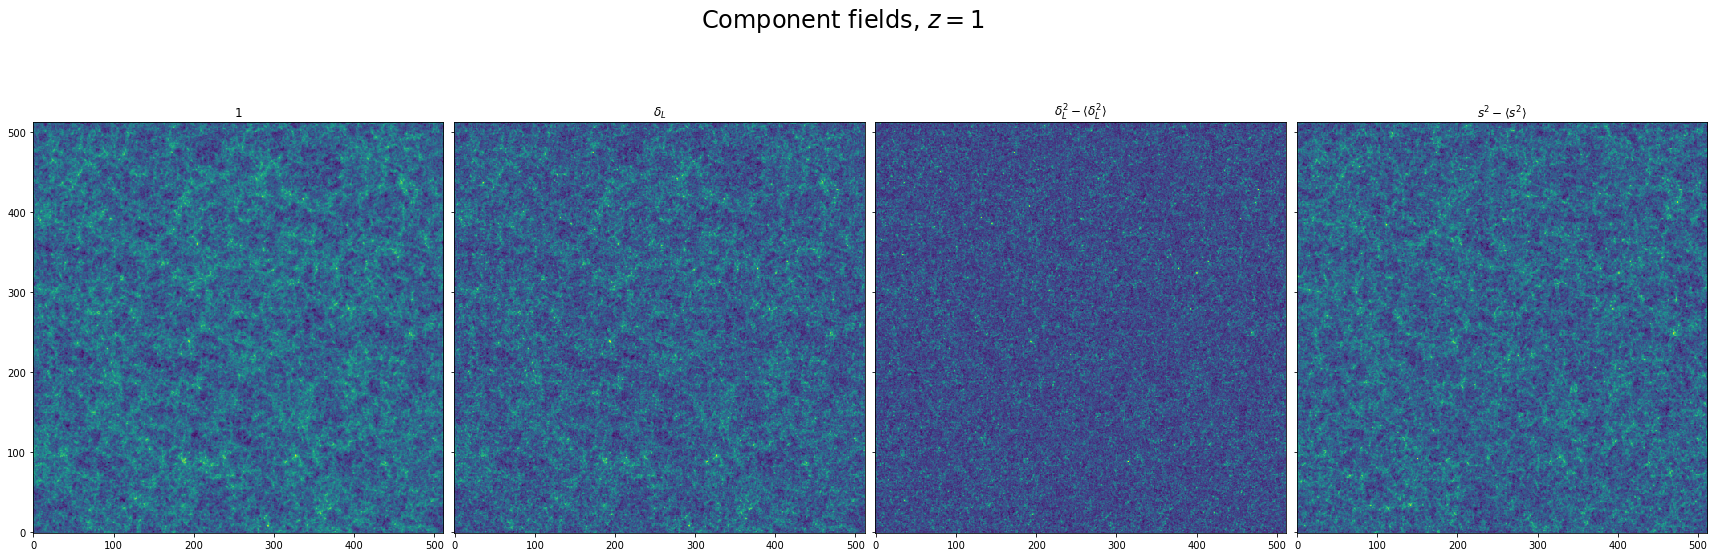

In [38]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(30, 15))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
                 share_all=True,
#                  cbar_location="right",
#                  cbar_mode="single",
#                  cbar_size="7%",
#                  cbar_pad=0.15,
                 )

maxval = np.max(sqfield.preview(axes=[0,1]))
minval = np.min(sqfield.preview(axes=[0,1]))

grid[0].imshow(field_late.preview(axes=[0,1]), origin='lower')
grid[0].set_title(r'$1$')

grid[1].imshow(field_linlate.preview(axes=[0,1]), origin='lower')
grid[1].set_title(r'$\delta_L$')

grid[2].imshow(field_sqlate.preview(axes=[0,1]), origin='lower')


im = grid[3].imshow(tide_sqlate.preview(axes=[0,1]), origin='lower')
grid[2].set_title(r'$\delta_L^2 - \langle \delta_L^2 \rangle $')

# grid[2].cax.colorbar(im)
# grid[2].cax.toggle_label(True)
grid[3].set_title(r'$s^2 - \langle s^2 \rangle $')

fig.suptitle('Component fields, $z=%s$'%z_late, y=0.8, fontsize=24)
fig.show()

# Power spectra

## LPT/CLEFT predictions

In [39]:
#stephen's predictions, get them from e-mail

pk = np.loadtxt('lpt_components_z1.0.dat').T

## Plots

### Triangle plot

13.712321281433105
24.799867630004883
36.100844621658325
48.0496244430542
59.8923716545105
70.03795647621155
112.58996748924255


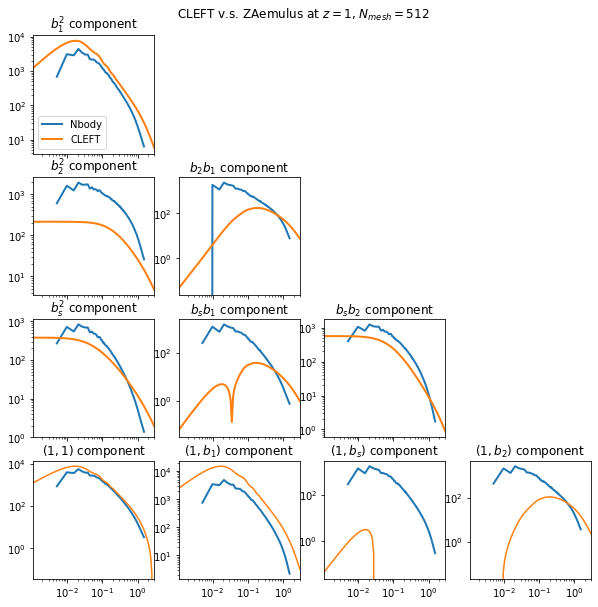

In [40]:
start_time = time.time()


fig, axes = plt.subplots(figsize=(10, 10), sharex=True, ncols=4, nrows=4)
x = np.linspace(0, 10, 100)
for i in range(4):
    for j in range(4):
        if i<j:
            axes[i, j].axis('off')

#Rescaling the weights by the growth ratios at the redshift of comparison
field_dict = {'1': field_late, r'$\delta_L$': growthratio*field_linlate, r'$\delta^2$': growthratio**2 * field_sqlate, r'$s^2$': growthratio**2 *tide_sqlate}


b1sq = FFTPower(field_dict[r'$\delta_L$'], '1d', second=field_dict[r'$\delta_L$'], BoxSize=Lbox, Nmesh=nmesh)
b1power = b1sq.power['power'].real

axes[0, 0].loglog(b1sq.power['k'], b1power, label=r'Nbody', lw=2)
axes[0, 0].loglog(pk[0], pk[5], lw=2, label=r'CLEFT')
axes[0, 0].set_title(r'$b_1^2$ component')
axes[0, 0].set_xlim(pk[0][1], pk[0][-1])

print (time.time() - start_time)
b2sq = FFTPower(field_dict[r'$\delta^2$'], '1d', second=field_dict[r'$\delta^2$'], BoxSize=Lbox, Nmesh=nmesh)
b2power = b2sq.power['power'].real
axes[1,0].loglog(b2sq.power['k'], b2power, label=r'Nbody', lw=2)
axes[1,0].loglog(pk[0], pk[8], lw=2, label=r'CLEFT')
axes[1,0].set_title(r'$b_2^2$ component')
print (time.time() - start_time)

b2b1 = FFTPower(field_dict[r'$\delta_L$'], '1d', second=field_dict[r'$\delta^2$'], BoxSize=Lbox, Nmesh=nmesh)
b2b1power = b2b1.power['power'].real

axes[1,1].loglog(b2b1.power['k'], b2b1power, label=r'Nbody', lw=2)
axes[1,1].loglog(pk[0], pk[7], lw=2, label=r'CLEFT')
axes[1,1].set_title('$b_2b_1$ component')

fig.suptitle(r'CLEFT v.s. ZAemulus at $z=%s$, $N_{mesh} = %s$'%(z_late,nmesh), y=0.92)
print (time.time() - start_time)


bs2 = FFTPower(field_dict[r'$s^2$'], '1d', second=field_dict[r'$s^2$'], BoxSize=Lbox, Nmesh=nmesh)
bs2power = bs2.power['power'].real
axes[2,0].loglog(bs2.power['k'], bs2power, label=r'Nbody', lw=2)
axes[2,0].loglog(pk[0], pk[12], lw=2, label=r'CLEFT')
axes[2,0].set_title(r'$b_s^2$ component')
print (time.time() - start_time)

bsb1 = FFTPower(field_dict[r'$s^2$'], '1d', second=field_dict[r'$\delta_L$'], BoxSize=Lbox, Nmesh=nmesh)
bsb1power = bsb1.power['power'].real

axes[2,1].loglog(bsb1.power['k'], np.abs(bsb1power), label=r'Nbody', lw=2)
axes[2,1].loglog(pk[0], np.abs(pk[10]), lw=2, label=r'CLEFT')
axes[2,1].set_title('$b_sb_1$ component')

print (time.time() - start_time)

bsb2 = FFTPower(field_dict[r'$s^2$'], '1d', second=field_dict[r'$\delta^2$'], BoxSize=Lbox, Nmesh=nmesh)
bsb2power = bsb2.power['power'].real

axes[2,2].loglog(bsb2.power['k'], np.abs(bsb2power), label=r'Nbody', lw=2)
axes[2,2].loglog(pk[0], np.abs(pk[11]), lw=2, label=r'CLEFT')
axes[2,2].set_title('$b_sb_2$ component')
print (time.time() - start_time)


nonlinsq = FFTPower(field_dict['1'], '1d', second=field_dict['1'], BoxSize=Lbox, Nmesh=nmesh)
nonlinsqpower = nonlinsq.power['power'].real
axes[3,0].loglog(nonlinsq.power['k'], np.abs(nonlinsqpower), label=r'Nbody', lw=2)
axes[3,0].loglog(pk[0], pk[1]+pk[2]+pk[3], label=r'CLEFT')
axes[3,0].set_title('$(1,1)$ component')




nonlinb1 = FFTPower(field_dict['1'], '1d', second=field_dict[r'$\delta_L$'], BoxSize=Lbox, Nmesh=nmesh)
nonlinb1power = nonlinb1.power['power'].real
axes[3,1].loglog(nonlinb1.power['k'], np.abs(nonlinb1power), label=r'Nbody', lw=2)
axes[3,1].loglog(pk[0], pk[4], label=r'CLEFT')
axes[3,1].set_title('$(1,b_1)$ component')


nonlinbs = FFTPower(field_dict['1'], '1d', second=field_dict[r'$s^2$'], BoxSize=Lbox, Nmesh=nmesh)
nonlinbspower = nonlinbs.power['power'].real
axes[3,2].loglog(nonlinbs.power['k'], np.abs(nonlinbspower), label=r'Nbody', lw=2)
axes[3,2].loglog(pk[0], pk[9], label=r'CLEFT')
axes[3,2].set_title('$(1,b_s)$ component')

nonlinb2 = FFTPower(field_dict['1'], '1d', second=field_dict[r'$\delta^2$'], BoxSize=Lbox, Nmesh=nmesh)
nonlinb2power = nonlinb2.power['power'].real
axes[3,3].loglog(nonlinb2.power['k'], np.abs(nonlinb2power), label=r'Nbody', lw=2)
axes[3,3].loglog(pk[0], pk[6], label=r'CLEFT')
axes[3,3].set_title('$(1,b_2)$ component')


print (time.time() - start_time)

axes[0,0].legend()
axes[0,0].legend()


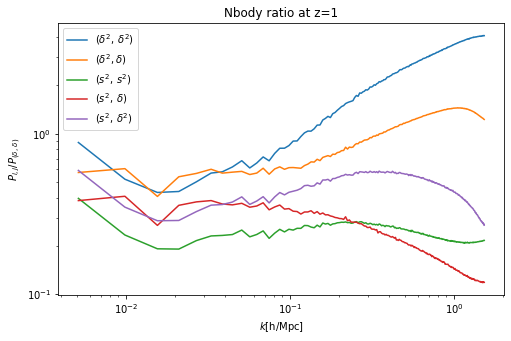

In [41]:
#ratio plots

plt.figure(figsize=(8, 5))
plt.plot(b1sq.power['k'], np.abs(b2power/b1power), label='$(\delta^2, \, \delta^2)$')
plt.plot(b1sq.power['k'], np.abs(b2b1power/b1power), label='$(\delta^2, \delta)$')
plt.plot(b1sq.power['k'], np.abs(bs2power/b1power), label='$(s^2, \, s^2)$')
plt.plot(b1sq.power['k'], np.abs(bsb1power/b1power), label='$(s^2, \, \delta)$')
plt.plot(b1sq.power['k'], np.abs(bsb2power/b1power), label='$(s^2, \, \delta^2)$')
plt.title('Nbody ratio at z=%s'%z_late)
plt.ylabel('$P_{i,j}/P_{(\delta,\, \delta)}$')
plt.xlabel(r'$k$[h/Mpc]')
# plt.ylim(1e-2, 2)
plt.legend()
plt.xscale('log')
plt.yscale('log')

Text(0.5, 1.0, '(1,1) v.s. $(\\delta_L, \\delta_L)$')

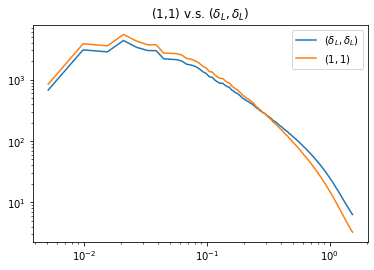

In [42]:
linlin = FFTPower(field_dict[r'$\delta_L$'], '1d', second=field_dict[r'$\delta_L$'], BoxSize=Lbox, Nmesh=nmesh)
nonlinnonlin = FFTPower(field_dict['1'], '1d', second=field_dict['1'], BoxSize=Lbox, Nmesh=nmesh)
plt.loglog(linlin.power['k'], linlin.power['power'].real, label='$(\delta_L, \delta_L)$')
plt.loglog(nonlinnonlin.power['k'], nonlinnonlin.power['power'].real, label='$(1,1)$')
plt.legend()
plt.title(r'(1,1) v.s. $(\delta_L, \delta_L)$')

# Theory v.s. measurement offset?

In [43]:
cleftspline = interp1d(pk[0], pk, axis=-1)

cleftpk = cleftspline(b1sq.power['k'])

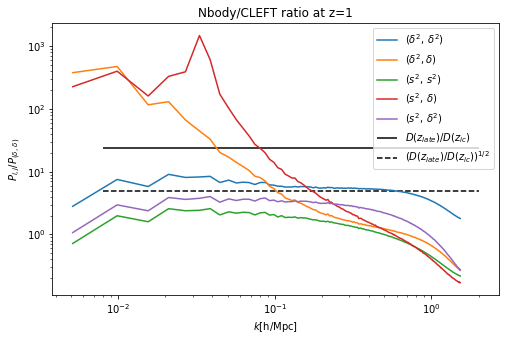

In [44]:
plt.figure(figsize=(8, 5))
plt.plot(b1sq.power['k'], np.abs(b2power/cleftpk[8]), label='$(\delta^2, \, \delta^2)$')
plt.plot(b1sq.power['k'], np.abs(b2b1power/cleftpk[7]), label='$(\delta^2, \delta)$')
plt.plot(b1sq.power['k'], np.abs(bs2power/cleftpk[12]), label='$(s^2, \, s^2)$')
plt.plot(b1sq.power['k'], np.abs(bsb1power/cleftpk[10]), label='$(s^2, \, \delta)$')
plt.plot(b1sq.power['k'], np.abs(bsb2power/cleftpk[12]), label='$(s^2, \, \delta^2)$')
plt.title('Nbody/CLEFT ratio at z=%s'%z_late)

#Some numerological quantities?
plt.hlines(growthratio, 8e-3, 2, label=r'$D(z_{late})/D(z_{ic})$')
plt.hlines(np.sqrt(growthratio), 8e-3, 2, ls='--', label=r'$(D(z_{late})/D(z_{ic}))^{1/2}$')

plt.ylabel('$P_{i,j}/P_{(\delta,\, \delta)}$')
plt.xlabel(r'$k$[h/Mpc]')
# plt.ylim(1e-2, 2)
plt.legend()
plt.xscale('log')
plt.yscale('log')